# Defining the aoi

In [1]:
import pandas as pd
import numpy as np
import xarray as xa
from pathlib import Path
import src.data.ecostress_io as eio
import rioxarray
import sys
import geopandas as gpd
import json
import dask
from dask.distributed import Client
import matplotlib.pyplot as plt

n_partitions = 8
root_path = Path("/mnt/ecostress/rhone-ecostress-data/")
tempdir = Path("/home/ryan/work/tmp")

with open(f"{root_path}/geo-countries/archive/countries.geojson", "rb") as f:
    all_countries_geojson = json.loads(f.read())


for i in all_countries_geojson['features']:
    if i['properties']['ADMIN'] == "France":
        france_geo = i


france_gdf = gpd.GeoDataFrame.from_features([france_geo]).explode()

france_gdf[france_gdf.area==max(france_gdf.area)].plot()

aoi = france_gdf[france_gdf.area==max(france_gdf.area)]

aoi_geojson = json.loads(aoi.to_json())

xmin, ymin, xmax, ymax = aoi.total_bounds
bounds_tuple = (4, 42, 7, 47)
xmin, ymin, xmax, ymax = bounds_tuple  # hardcoding since concattenating 1000s of ecostress files with different overlaps hangs

# Global rivers dataset

In [2]:
rivers_df = gpd.read_file(Path(root_path, "europe_rivers/eu_river.shp"))

rivers_df['R_ID'] = rivers_df['R_ID'].apply(int).apply(str)

france_rivers_df = rivers_df.cx[xmin:xmax, ymin:ymax]

aoi.crs = france_rivers_df.crs # setting crs for aoi

### Check to make sure they overlay, geopandas has poor support for linestrings so we subset by the bounding box

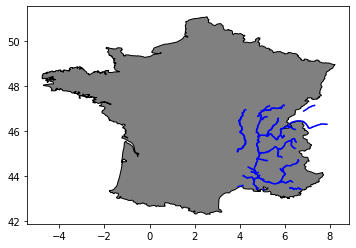

In [3]:
base = aoi.plot(color="grey", edgecolor="black")

france_rivers_df.plot(ax=base, color="blue")

## reading in paths and example data array

In [4]:
qa_path = Path(root_path, "ECO3ANCQA")
et_path = Path(root_path, "ECO3ETPTJPL")
esi_path = Path(root_path, "ECO4ESIPTJPL")

whole_tif_qa_paths, csv_qa_paths, xml_qa_paths = eio.separate_extensions(qa_path)

whole_tif_etdaily_paths, csv_et_paths, xml_et_paths = eio.separate_extensions(et_path, "*ETdaily*.tif")

Clipping all et tifs, takes about 10 min with threading. 

In [6]:
clipped_scene_paths = [Path(p) for p in tempdir.glob("*clipped*")]

if clipped_scene_paths == []:
    client = Client()
    
    batches = eio.batches_from(whole_tif_etdaily_paths, 8)
    
    batch_results = []
    
    for batch in batches:
    
        batch_result = dask.delayed(eio.clip_and_save)(batch, bounds_tuple, filter_nan = True, outDir=tempdir)
        batch_results.append(batch_result)
        
    result_futures = client.compute(batch_results, scheduler='processes')

    clipped_scene_batches = [i.result() for i in result_futures]# gets rid of None that denotes too little scene overlap
    clipped_scene_paths = []
    for batch in clipped_scene_batches:
        for path in batch:
            if path != None:
                clipped_scene_paths.append(Path(path))

In [7]:
france_river_lines = france_rivers_df.copy()
buffered_france_rivers_df = france_rivers_df.to_crs(epsg=2154)\
                                            .buffer(5000)\
                                            .to_crs(epsg=4326) # buffers by 5000 meters
france_rivers_df['geometry'] = buffered_france_rivers_df

/data/anaconda/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [8]:
resolution = eio.read_ecostress_scene(clipped_scene_paths[0]).rio.resolution()
crs = france_rivers_df.crs
aoi_grid = eio.gdf_to_dataarray(france_rivers_df, crs, resolution)

In [9]:
resampled_scene_paths = [Path(p) for p in tempdir.glob("*resampled*")]

if resampled_scene_paths == []:
    client = Client()
    batches = eio.batches_from(clipped_scene_paths, n_partitions)

    def wrapper(paths, aoi_grid, tempdir, path_id):
        return_paths = []
        for path in paths:
            x = eio.read_mask_ecostress_scene(path)
            y = eio.resample_xarray_to_basis(x, aoi_grid)
            return_paths.append(eio.write_tmp(y, tempdir, path_id))
        return return_paths

    all_results = []
    for batch in batches:
        sub_result = dask.delayed(wrapper)(batch, aoi_grid, tempdir, "resampled")
        all_results.append(sub_result)
        
    result_future = client.compute(all_results, scheduler="processes")
    
    resampled_scene_batches = [i.result() for i in result_future]
    resampled_scene_paths = []
    for batch in resampled_scene_batches:
        for path in batch:
            if path != None:
                resampled_scene_paths.append(Path(path))

In [10]:
resampled_data_arrays = eio.read_scenes(resampled_scene_paths)

In [11]:
et_tseries = xa.concat(resampled_data_arrays, dim="date").sortby('date')

In [12]:
from geocube.api.core import make_geocube
france_rivers_df['value'] = 1 # allow sus to make non empty dataset, required for resampling
river_arr = make_geocube(vector_data=france_rivers_df, resolution=resolution)['value']

/data/anaconda/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
reanalysis_path = Path(root_path, "era5-download.nc")

In [14]:
met_dataset = xa.open_dataset(reanalysis_path, chunks = {"time": 1, "latitude": 39, "longitude": 41})

In [15]:
met_dataset['vpd'] = eio.vapor_deficit(met_dataset['t2m']-273.15,met_dataset['d2m']-273.15)

In [16]:
met_dataset = met_dataset.rio.set_crs(4326)

In [17]:
vpd = met_dataset['vpd']

Need to reduce hourly vpd before reprojecting because too much memory

local time in utc is 1 hour behind paris, so I take the mean of vpd over 10am-3pm local time

In [18]:
daytime_mask = np.isin(vpd.time.dt.hour, [9, 10, 11, 12, 13, 14])

In [19]:
daytime_vpd = vpd.isel(time=daytime_mask)

In [20]:
daytime_vpd_daily = daytime_vpd.resample(time="1D").mean()

In [21]:
daytime_vpd_daily = daytime_vpd_daily.rio.set_crs(4326)

I need this much mem to reproject...

In [22]:
np.float32(1).itemsize * np.prod([395, 6101, 6558]) / 1e9

63.21636564

In [44]:
from rasterio.enums import Resampling
import os
dataset_filename = "Daily_VPD_10am-3pm_Paris_Time_Resampled.nc"
dataset_name = dataset_filename.split(".")[0]
resampled_vpd_path = os.path.join(root_path, dataset_filename)

if os.path.isfile(resampled_vpd_path):
    
    resampled_vpd_ds = xa.open_dataset(resampled_vpd_path, chunks = {"time": 1, "y": 6101, "x": 6558})
    resampled_vpd_da = resampled_vpd_ds[dataset_name]
else:

    resampled_vpd_da = daytime_vpd_daily.rio.reproject_match(et_tseries[0], resampling = Resampling.bilinear)

    resampled_vpd.name = dataset_name
    
    eio.write_netcdf(resampled_vpd_da, resampled_vpd_path)
    
    del resampled_vpd_da
    
    resampled_vpd_ds = xa.open_dataset(resampled_vpd_path, chunks = {"time": 1, "y": 6101, "x": 6558})
    resampled_vpd_da = resampled_vpd_ds[dataset_name]

No interpolation, aggregated daily VPD

/data/anaconda/envs/geo/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


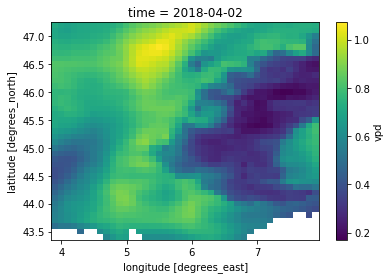

In [36]:
daytime_vpd_daily[1].plot.imshow()

Resampled with Bilinear interpolation

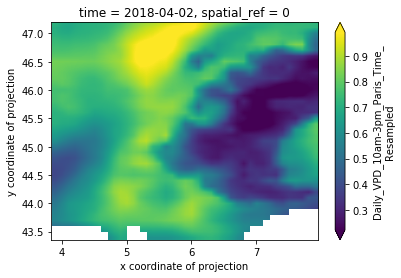

In [38]:
resampled_vpd_da[1].plot.imshow(robust=True)

In [43]:
et_tseries = et_tseries.rename({'date':'time'})

<xarray.Dataset>
Dimensions:                                                                                          (time: 101, x: 6558, y: 6101)
Coordinates:
  * x                                                                                                (x) float64 7.957 ... 3.827
  * y                                                                                                (y) float64 43.35 ... 47.2
    band                                                                                             int64 1
  * time                                                                                             (time) datetime64[ns] 2018-07-29T17:12:56 ... 2019-10-16T09:41:20
Data variables:
    ECO3ETPTJPL001_EVAPOTRANSPIRATION_PT_JPL_ETdaily_doy2019240051431_aid0001-clipped-resampled.tif  (time, y, x) float32 dask.array<chunksize=(1, 6101, 6558), meta=np.ndarray>

In [55]:
resampled_vpd.sel(time=slice("2018-07","2018-09"))['time']

<xarray.DataArray 'time' (time: 92)>
array(['2018-07-01T00:00:00.000000000', '2018-07-02T00:00:00.000000000',
       '2018-07-03T00:00:00.000000000', '2018-07-04T00:00:00.000000000',
       '2018-07-05T00:00:00.000000000', '2018-07-06T00:00:00.000000000',
       '2018-07-07T00:00:00.000000000', '2018-07-08T00:00:00.000000000',
       '2018-07-09T00:00:00.000000000', '2018-07-10T00:00:00.000000000',
       '2018-07-11T00:00:00.000000000', '2018-07-12T00:00:00.000000000',
       '2018-07-13T00:00:00.000000000', '2018-07-14T00:00:00.000000000',
       '2018-07-15T00:00:00.000000000', '2018-07-16T00:00:00.000000000',
       '2018-07-17T00:00:00.000000000', '2018-07-18T00:00:00.000000000',
       '2018-07-19T00:00:00.000000000', '2018-07-20T00:00:00.000000000',
       '2018-07-21T00:00:00.000000000', '2018-07-22T00:00:00.000000000',
       '2018-07-23T00:00:00.000000000', '2018-07-24T00:00:00.000000000',
       '2018-07-25T00:00:00.000000000', '2018-07-26T00:00:00.000000000',
       '2018-0

In [84]:
et_tseries_ds = et_tseries.to_dataset().sel(band=1)

In [90]:
et_tseries_ds['time'] = et_tseries_ds['time'].values.astype('datetime64[D]')

In [92]:
resampled_vpd['time'] = resampled_vpd['time'].values.astype('datetime64[D]')

Frick. Need to merge ET arrays taken on same date together to reduce time coord duplicates that occur because of partial scene overlaps and large aoi. nanmean should replace nans with a true value, 2 or more true values with the mean for that day (should only happena t the overlaps, infrequently), and all nan slices with nan.

In [123]:
duplicated_mask = pd.to_datetime(np.array(et_tseries_ds['time'])).duplicated(keep=False)

In [124]:
duplicate_dates = np.unique(et_tseries_ds.isel(time=duplicated_mask)['time'])

In [125]:
duplicated_da = et_tseries_ds.isel(time=duplicated_mask).sel()

In [129]:
for duplicate in duplicate_dates:
    np.nanmean(et_tseries.sel(time=duplicate))

KeyError: 1532995200000000000

In [94]:
resampled_vpd.merge(et_tseries_ds,join='inner')

ValueError: cannot reindex or align along dimension 'time' because the index has duplicate values

Plotting ecostress availability

In [ ]:
et_tseries = et_tseries.sel(band=1)

et_2018_may_sept=et_tseries.sel(date=slice("2018-06-01", "2018-09-30"))

et_2018_may_sept=et_2018_may_sept.chunk(chunks={"date": 101, "y": 1000, "x": 1000})

et_2018_may_sept = et_2018_may_sept.where(et_2018_may_sept > 0)

et_nonnan_count = ~np.isnan(et_2018_may_sept)

true_count = et_nonnan_count.astype(bool).sum(dim="date")

true_count_c = true_count.compute()

f, ax = plt.subplots(1)
true_count_c.plot.imshow(ax=ax)
plt.title("Number of ECOSTRESS Observations, May-Sept 2018")
france_river_lines.plot(ax=ax, color="red")

Aggregating hourly data to dekad

In [ ]:
pev_dekad = met_dataset['pev'].resample(time='1D').sum().resample(time='10D').mean()

pev_dekad_2018 = pev_dekad.sel(time=slice("2018-01-01", "2018-10-01"))

met_dataset['pev'].sel(time="2019-04-01")

pev_dekad_2019.plot(x='longitude', y='latitude', col='time', col_wrap=5)

## pretty ET plotting

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
%matplotlib inline

ETcolors = ["#f6e8c3", "#d8b365", "#99974a", "#53792d", "#6bdfd2", "#1839c5"]
ETcmap = LinearSegmentedColormap.from_list("ET", ETcolors)
date_utc = pd.to_datetime(et['date'].values)
layer_type = et.attrs['filename'].split("_")[-3]
title = 'ECO3ETPTJPL Evapotranspiration'

fig = plt.figure(figsize=(9.7,7.6))                                                       # Set the figure size (x,y)
fig.suptitle(f'{title} ({layer_type}) \n at {date_utc}', fontsize=22)  # Add title for the plots
plt.axis('off')                                                                           # Remove axes from plot
im = plt.imshow(et.sel(band=1), cmap=ETcmap);                                                        # Plot array using colormap
# plt.scatter(Tcol, Trow, color="black", marker='x')                                        # Plot tower location
# Add a colormap legend
plt.colorbar(im, orientation='horizontal', fraction=0.05, pad=0.004, label=f"ET ({et.attrs['units']})", shrink=0.6).outline.set_visible(True)

## Code graveyard

trying to plot xarray image data and geopandas data with ipyleaflet but it can't do image overlays yet (unless it comes from a server via url potentially)

In [ ]:
import ipyleaflet as ipyl
x = france_river_lines.unary_union.envelope.centroid.xy[0][0]
y = france_river_lines.unary_union.envelope.centroid.xy[1][0]
e, n, w, s =true_count_c.rio.bounds()
m = ipyl.Map(center = (y,x), zoom=6)

rivers_data = ipyl.GeoData(geo_dataframe = france_river_lines,
                   style={'color': 'purple', 'opacity':3, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Rivers')
m.add_layer(rivers_data)
plt.imsave("observation_count.jpeg",true_count_c)
obs_heatmap = ipyl.ImageOverlay(
    url="observation_count.jpeg",
    bounds=((s, w), (n, e))
)

m.add_layer(obs_heatmap)
m

trying to plot ecostress DataArray with geopandas shapes

In [ ]:
def cartopy_project_geo_df(df, crs):

    # This can be converted into a `proj4` string/dict compatible with GeoPandas
    crs_proj4 = crs.proj4_init
    return df.to_crs(crs_proj4)

crs = ccrs.PlateCarree()
aoi_projected = cartopy_project_geo_df(aoi, crs)
france_rivers_df_projected = cartopy_project_geo_df(france_rivers_df, crs)
# base = aoi_projected.plot(color="grey", edgecolor="black")
# france_rivers_df_projected.plot(ax=base, color="blue")


import cartopy.crs as ccrs
import matplotlib.pyplot as plt
ax = plt.axes(projection=crs)
all_et_daily[14].sel(band=1).plot.imshow(ax=ax, transform=crs)
# ax.add_geometries(aoi_projected['geometry'], crs=crs)
ax.add_geometries(france_rivers_df_projected['geometry'], crs=crs)

In [ ]:
def mask_NA_values():
    """
    Daily ET products have both nan values from where there are clouds 
    and -1e+13 for where the ecostress swath was clipped during the ordering process
    """
    masked_et = np.ma.masked_where(et.sel(band=1) == np.nan, et.sel(band=1))
    masked_et = np.ma.masked_where(masked_et == -1e+13, masked_et)